# Bayesian RNN

In [1]:
#### -----
import matplotlib.pyplot as plt
def putStyle(sFont,syT,top1,R1):
    import matplotlib as mpl
    import matplotlib.style as style

    style.available

    # General plot parameters
    mpl.rcParams['font.family'] = 'Avenir'
    mpl.rcParams['font.size'] = sFont
    mpl.rcParams['axes.linewidth'] = 4
    mpl.rcParams['axes.spines.bottom'] = top1
    mpl.rcParams['axes.spines.right'] = R1
    mpl.rcParams['xtick.major.size'] = 10
    mpl.rcParams['xtick.major.width'] = 2
    mpl.rcParams['ytick.major.size'] = 10
    mpl.rcParams['ytick.major.width'] = syT
    mpl.rcParams['lines.linewidth']= 3
    mpl.rcParams["figure.figsize"] = (5,5)
    #mpl.rcParams['axes.title.pad'] = 20
    mpl.rcParams["axes.titlepad"] = 20

In [2]:
import theano
import theano.tensor as T
import numpy as np
import collections

import pymc3 as pm
import seaborn as sns

## --------------------------------------------------
from warnings import filterwarnings
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")

In [3]:
text = ''
vocab = set()
alice_txt = 'alice.txt'
with open(alice_txt) as file:
    content = file.read()
    text += content
    vocab = vocab.union(set(content))
# ----
vocab_size = len(vocab)
print(f'The vocab size is {vocab_size}')


The vocab size is 34


In [4]:
def _to_label(index):
    label = np.zeros(vocab_size)
    label[index] = 1.0
    return label

In [5]:
# Let's take only 10 lines
text1 = text.split('\n')[:10]
#text1, \
text2 = text[:469]
characters = sorted(list(set(text2)))
n_to_char = {n: char for n, char in enumerate(characters)}
char_to_n = {char: n for n, char in enumerate(characters)}
text2

"  achilles' wrath, to greece the direful spring\n  of woes unnumber'd, heavenly goddess, sing!\n  that wrath which hurl'd to pluto's gloomy reign\n  the souls of mighty chiefs untimely slain\n  whose limbs unburied on the naked shore,\n  devouring dogs and hungry vultures tore.\n  since great achilles and atrides strove,\n  such was the sovereign doom, and such the will of jove!\n  declare, o muse! in what ill-fated hour\n  sprung the fierce strife, from what offended power"

In [6]:
X1 = []
X1text=[]
Y1 = []
length = len(text2)
seq_length = 20
for i in range(0, length - seq_length, 1):
    sequence = text2[i:i + seq_length]
    label = text2[i + seq_length]
    X1.append([char_to_n[char] for char in sequence])
    X1text.append([char_to_n[char] for char in sequence])
    Y1.append(char_to_n[label])

# -- Some scaling --
Y1 = np.array([_to_label(i) for k, i in enumerate(Y1)])
X1 = np.reshape(X1, (len(X1), seq_length))
X1 = X1 / float(len(characters))
X1 = np.array(X1)

In [7]:
X1.shape, Y1.shape

((449, 20), (449, 34))

In [8]:
nExplore=20
print('This is the text in float numbers: ',X1[0][:nExplore])
print('In integer:', X1text[0][:nExplore])
print('In letters:', [n_to_char[s] for s in X1text[0][:nExplore]])
print('And joined:', ''.join([n_to_char[s] for s in X1text[0][:nExplore]]))

This is the text in float numbers:  [0.03333333 0.03333333 0.23333333 0.3        0.46666667 0.5
 0.6        0.6        0.36666667 0.8        0.1        0.03333333
 0.93333333 0.76666667 0.23333333 0.83333333 0.46666667 0.13333333
 0.03333333 0.83333333]
In integer: [1, 1, 7, 9, 14, 15, 18, 18, 11, 24, 3, 1, 28, 23, 7, 25, 14, 4, 1, 25]
In letters: [' ', ' ', 'a', 'c', 'h', 'i', 'l', 'l', 'e', 's', "'", ' ', 'w', 'r', 'a', 't', 'h', ',', ' ', 't']
And joined:   achilles' wrath, t


## la funcion para recorrer las capas ocultas ...

In [9]:
def step(x_t, h_tm1, Waa, Wax, Wya, baa, bya):
    h_t = activ(T.dot(h_tm1, Waa)   +    T.dot(x_t, Wax) +    baa)
    a_last1 = T.dot(h_t, Wya) + bya
    #-- Output
    y_hat1 = T.nnet.softmax(a_last1)
    return [h_t , y_hat1]

---

# Keep working

In [10]:
X1.shape[1],  5,  Y1.shape[1]

(20, 5, 34)

In [11]:
# nin = es la dimension de cada secuencia, de cada Row de X, de cada sample !
# n_hidden = es cuantas capas Hidden hay?
# nout = es la dimension del vector de salida, de cada Sample, el vocabulario en este caso!

nin, n_hidden, nout = X1.shape[1],  20,  Y1.shape[1]


# -- Activation functions --
activ = T.nnet.sigmoid
rng = np.random.RandomState(1234)
# this is where we keep shared weights that are optimised during training
params = collections.OrderedDict()


'''define symbolic variables'''
lr = T.scalar()
x = T.matrix()
y = T.matrix()

'''define shared variables'''
Wax = np.asarray(rng.normal(size=(nin, n_hidden), scale=.01, loc=.0), dtype=theano.config.floatX)
Waa = np.asarray(rng.normal(size=(n_hidden, n_hidden), scale=.01, loc=.0), dtype=theano.config.floatX)
Wya = np.asarray(rng.normal(size=(n_hidden, nout), scale=.01, loc=0.0), dtype=theano.config.floatX)
baa = np.zeros((n_hidden,), dtype=theano.config.floatX)
bya = np.zeros((nout,), dtype=theano.config.floatX)

In [12]:
Waa

array([[-2.26632294e-03, -9.23830720e-03,  3.55838997e-03,
        -1.27006348e-02, -1.95472413e-03, -4.63419399e-03,
         9.89414847e-03,  1.38864738e-02,  1.08771374e-02,
         4.38801263e-03, -9.61602241e-03,  1.24560994e-02,
         5.02925518e-03, -6.31398778e-03, -7.04252047e-03,
        -2.40482537e-03,  5.85599311e-03,  3.52800560e-03,
        -1.81555769e-02, -9.10123846e-03],
       [-7.48527953e-03, -1.08124926e-03,  2.74778837e-03,
         2.37349765e-03, -2.59843694e-03, -3.12442177e-03,
         4.48509743e-03, -5.95319647e-04, -4.70014813e-03,
         3.49566772e-03, -1.02746885e-02, -3.06638484e-03,
         1.40617614e-02, -1.24969677e-02, -1.56014889e-02,
         1.55739765e-02, -5.93356395e-03, -1.70288512e-03,
         1.67262681e-02, -5.40799808e-03],
       [-6.84128329e-03,  5.99962086e-03, -2.17199125e-03,
         3.31526518e-03, -3.83364580e-03, -7.81816088e-03,
         2.66237407e-03,  2.79428025e-03, -1.21962570e-02,
        -7.23948917e-03, -1.7

In [13]:
# --- Turning them into Theano's objects ---
Wax = theano.shared(Wax, 'Wax')
Waa = theano.shared(Waa, 'Waa')
Wya = theano.shared(Wya, 'Wya')
baa = theano.shared(baa, 'baa')
bya = theano.shared(bya, 'bya')


## -- Initial conditions --
h0_tm1 = theano.shared(np.zeros(n_hidden, dtype=theano.config.floatX))


# -- [Computational Graph]
[h, predictions], updates = theano.scan(fn=step,
                                        sequences= x,
                                        outputs_info=[h0_tm1, None],
                                        non_sequences=[Waa, Wax, Wya, baa, bya])

## A function for the Predictions --
prediction = theano.function(inputs=[], outputs=predictions,
                             givens=[(x,X1)])


---
# For the running of PyMC3

In [14]:
train_input_var = theano.shared(np.asarray(X1).astype(np.float64))
train_target_var = theano.shared(np.asarray(Y1).astype(np.float64))

---
# Ok! PyMC3

In [15]:
with pm.Model() as Brnn:
    print("Building BNetwork ......")

    Wax=pm.Normal('Wax', 0, sd=1,
                  shape=(nin, n_hidden),)

    Wya=pm.Normal('Wya', 0, sd=1,
                  shape=(n_hidden, nout),)

    Waa=pm.Normal('Waa', 0, sd=1,
                  shape=(n_hidden, n_hidden),)

    bya=pm.Normal('bya', 0, sd=1,
                   shape=(n_hidden, ),)

    baa=pm.Normal('baa', 0, sd=1,
                  shape=(nout, ),)

    train_prediction = theano.function(inputs=[], outputs=predictions,
                                       givens=[(x,train_input_var)])
    train_pres = train_prediction()
    def LogLik(y_hat1, yobs):
        return  -(yobs*T.log(y_hat1) + (1.-yobs)*T.log(1.-y_hat1)).mean(axis=0).sum()

    out = pm.DensityDist('out', LogLik, observed={'yobs': train_target_var, 'y_hat1':train_pres})

Building BNetwork ......


In [16]:
with Brnn:
    #Run ADVI which returns posterior means, standard deviations,
    #and the evidence lower bound (ELBO)
    v_params = pm.ADVI(n=400)
#    trace = pm.sample(v_params, draws=50)
    approx = pm.fit(
        n=800,
        method=v_params,
    )

Finished [100%]: Average Loss = -1,902.9


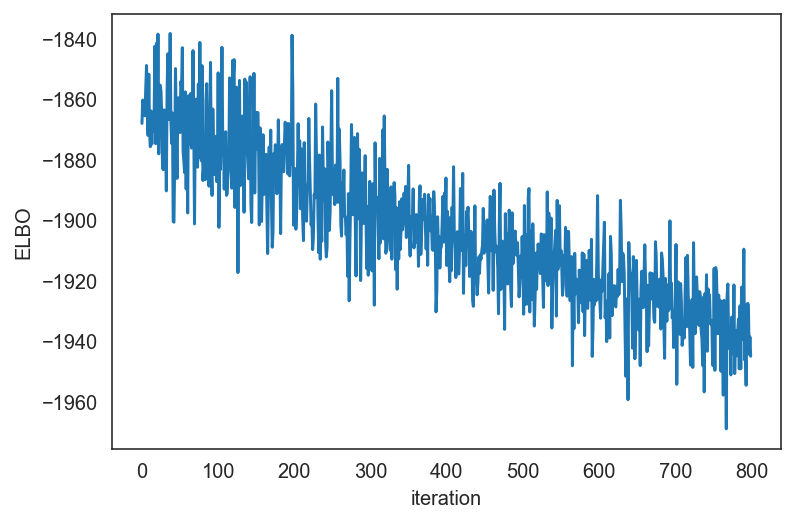

In [19]:
plt.plot(v_params.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration')
plt.savefig('ELBO_theanos2.png')

In [22]:
trace = approx.sample(draws=400)
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
arviz - WARNING - Shape validation failed: input_shape: (1, 400), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"Wax[0, 0]",0.011,0.715,-1.346,1.220,0.041,0.029,326.0,300.0,NaN
"Wax[0, 1]",0.037,0.772,-1.347,1.535,0.046,0.033,270.0,319.0,NaN
"Wax[0, 2]",0.030,0.782,-1.331,1.629,0.041,0.029,374.0,399.0,NaN
"Wax[0, 3]",0.028,0.793,-1.402,1.457,0.041,0.029,377.0,356.0,NaN
"Wax[0, 4]",-0.032,0.776,-1.482,1.340,0.042,0.030,341.0,331.0,NaN
...,...,...,...,...,...,...,...,...,...
baa[29],-0.024,0.750,-1.489,1.249,0.034,0.030,486.0,366.0,NaN
baa[30],-0.014,0.818,-1.380,1.533,0.038,0.029,456.0,312.0,NaN
baa[31],0.009,0.752,-1.311,1.345,0.044,0.031,294.0,365.0,NaN
baa[32],-0.055,0.761,-1.472,1.314,0.037,0.027,423.0,372.0,NaN


In [ ]:
#pm.traceplot(trace)

In [20]:
import warnings

import arviz as az
#import matplotlib.pyplot as plt
#import numpy as np
#import pymc3 as pm
#import theano.tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-whitegrid")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")


Running on PyMC3 v3.11.4
Running on ArviZ v0.11.4


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


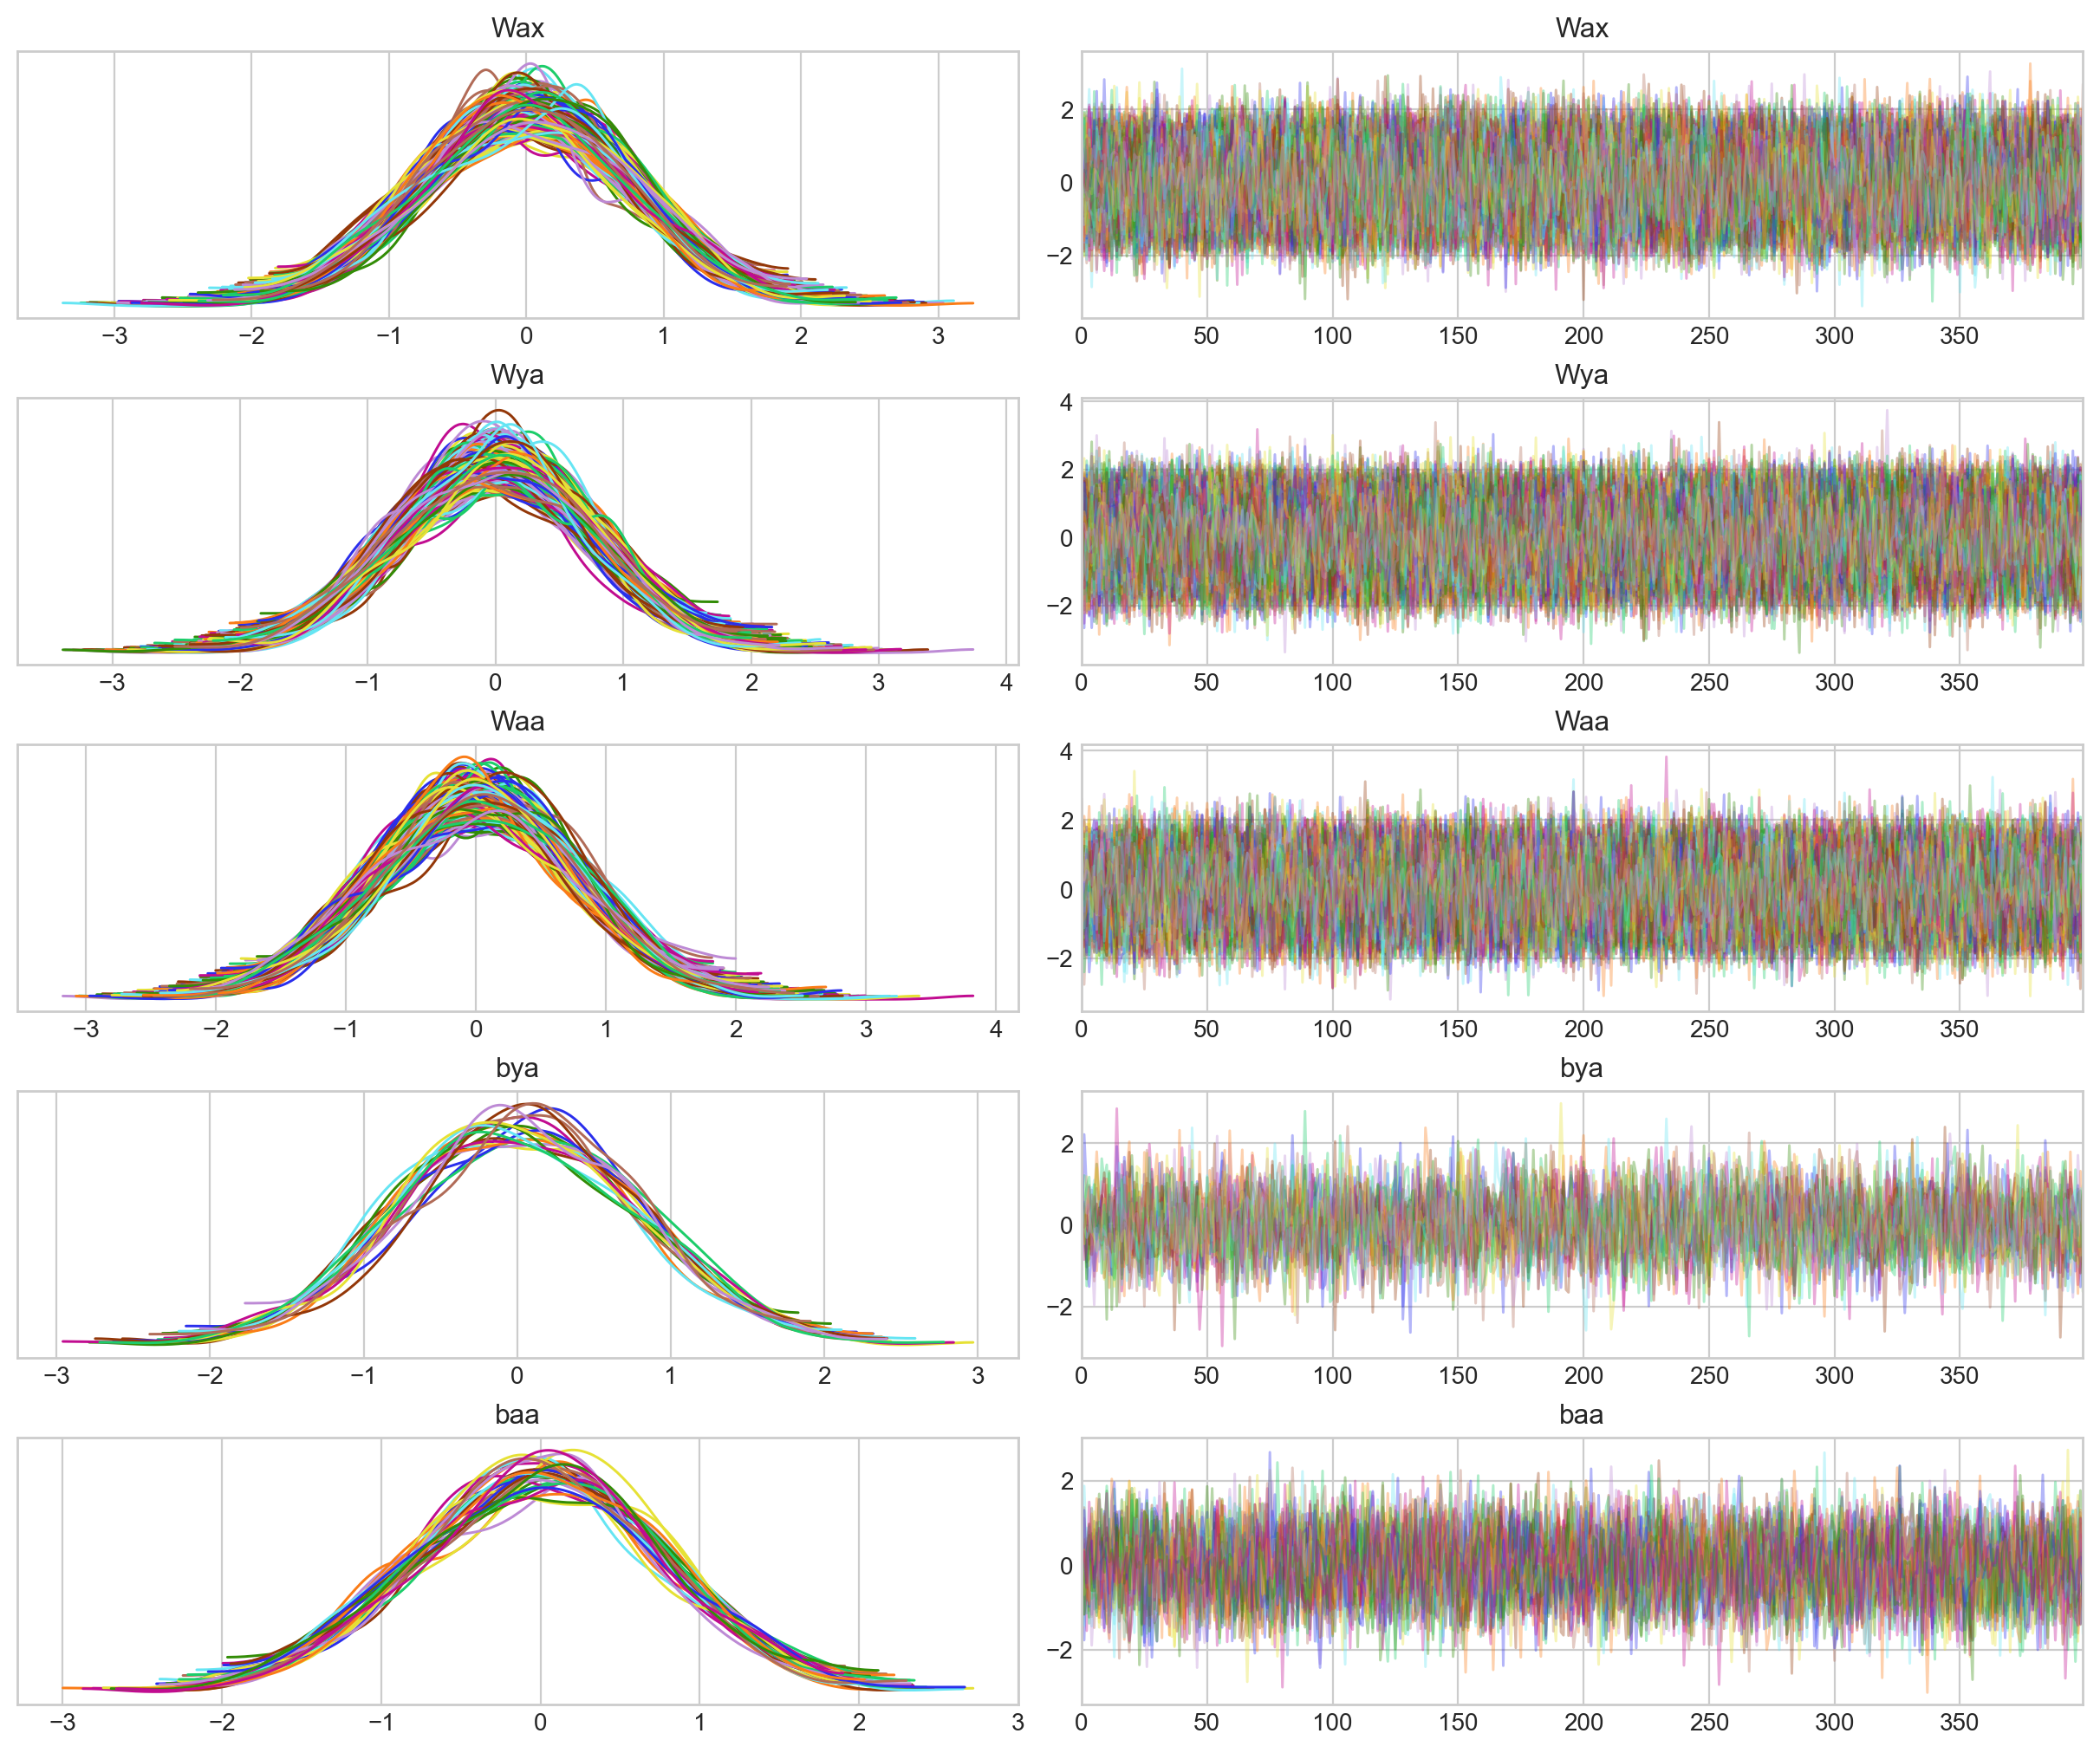

In [23]:
az.plot_trace(trace)

fig = plt.gcf() # to get the current figure...
fig.savefig("Theano2_final plot_v1.png") # and save it directly